# Component 2

# Big Data Coursework

This notebook contains the code and accompanying comments which can be run on the Lena PySpark network.

This notebook may also be used to run the project in Jupyter Notebook through the following libraries.

### Technologies implemented in this notebook
1.	Hadoop - for storing the large file on the Lena network
2.	Apache Spark - for running the code found in this notebook
3.	Spark ML - a higher level API for use with DataFrames in building machine learning pipelines.

## Importing Necessary Libraries

In [1]:
# Importing system libraries.
import os
import sys

# Importing pyspark libraries.
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col
import pyspark.sql.functions as fn
import pyspark.mllib.stat as st
from pyspark.ml import Pipeline
from pyspark.ml.stat import ChiSquareTest

# Cross validation and evaluation libraries.
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

# ML models for regression.
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor

# Scaling and encoding libraries.
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler

# General use libraries.
import numpy as np

# Visualisation Libraries.
from handyspark import *
from matplotlib import pyplot as plt

# Library for unique id creation.
from pyspark.sql.functions import monotonically_increasing_id

# Setting up the pyspark environment.
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ ["SPARK_HOME"] = "C:\spark-3.2.1-bin-hadoop3.2" 

In [2]:
# Start pyspark session.
spark = SparkSession.builder.appName('CW').getOrCreate()

## Importing the Dataset

Creating the schema for the dataset in order to import the dataframe correctly.

In [3]:
schema = StructType([
    StructField('id', StringType(), True),
    StructField('url', StringType(), True),
    StructField('region', StringType(), True),
    StructField('region_url', StringType(), True),
    StructField('price', IntegerType(), True),
    StructField('type', StringType(), True),
    StructField('sqfeet', IntegerType(), True),
    StructField('beds', IntegerType(), True),
    StructField('baths', IntegerType(), True),
    StructField('cats_allowed', IntegerType(), True),
    StructField('dogs_allowed', IntegerType(), True),
    StructField('smoking_allowed', IntegerType(), True),
    StructField('wheelchair_access', IntegerType(), True),
    StructField('electric_vehicle_charge', IntegerType(), True),
    StructField('comes_furnished', IntegerType(), True),
    StructField('laundry_options', StringType(), True),
    StructField('parking_options', StringType(), True),
    StructField('image_url', StringType(), True),
    StructField('description', StringType(), True),
    StructField('lat', StringType(), True),
    StructField('long', StringType(), True),
    StructField('state', StringType(), True)
])

#### Dataset location on the HFDS: hdfs://lena/user/spapa001/housing.csv

In [4]:
# Loading the dataset into the dataframe using the previously defined schema.
df = spark.read.csv('housing.csv', header=True, schema=schema)

## Exploratory Data Analysis

This section will focus on examining the dataset for duplicates, missing values and other potential issues which may hamper the model creation process.

There are a number of columns in this dataset that provide little to no value to analysis and model creation and will therefore be dropped.

In [5]:
# Dropping columns.
housing_df = df.drop('id', 'url', 'region_url', 'image_url', 'description', 'lat', 'long')

The dataset is poorly visualised using the standard pyspark method i.e. housing_df.show()

As such the .toPandas function is used to better portray the data.

In [6]:
# Examining the dataset in pandas format.
housing_df.toPandas()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,state
0,reno / tahoe,1148.0,apartment,1078.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,w/d in unit,carport,ca
1,reno / tahoe,1200.0,condo,1001.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,w/d hookups,carport,ca
2,reno / tahoe,1813.0,apartment,1683.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,w/d in unit,attached garage,ca
3,reno / tahoe,1095.0,apartment,708.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,w/d in unit,carport,ca
4,reno / tahoe,289.0,apartment,250.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,laundry on site,None,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384975,reno / tahoe,1295.0,apartment,957.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,w/d in unit,carport,ca
384976,reno / tahoe,1549.0,apartment,1034.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,w/d in unit,None,ca
384977,reno / tahoe,1249.0,apartment,840.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,laundry on site,off-street parking,ca
384978,reno / tahoe,1429.0,apartment,976.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,w/d in unit,carport,ca


Using the describe function to get a quick overview of the dataset, as standard in data exploration.

In [7]:
# Using the describe function to provide basic dataset satistics.
housing_df.select('price', 'sqfeet', 'beds', 'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed', 
                  'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished').describe().toPandas()

,summary,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished
0,count,384976,384977,384977,343150,384977,384977,384977,384977,384977,384977
1,mean,1634.8885437014255,1059.899565428584,1.9053449946360432,1.4313448929039778,0.7268901778547809,0.7079176158575707,0.7317709889162209,0.0821113988627892,0.012870898780966136,0.04812755047704149
2,stddev,69298.20926542193,19150.757244214434,3.494571619825252,0.6039947137880883,0.44555736203516577,0.45472057586523185,0.4430380554224405,0.2745347206014748,0.11271766386957122,0.21403599781322144
3,min,0,0,0,0,0,0,0,0,0,0
4,max,21701907,8388607,1100,75,1,1,1,1,1,1


A potential issue is observed in the 'price', 'sqfeet', 'beds' and 'baths' columns. All features show a minimum value of 0, which may be incorrect and needs to be validated before proceeding further. With regards to the first two columns there cannot be a 'free' house on the market nor can anything be sold with '0' square feet. As such a closer investigation into these values must be undertaken.

It is also interesting to note the large disparity between the maximum 'price', 'sqfeet', 'beds' and 'baths' features compared to the average for the dataset. There clearly exists a section of very large and expensive houses which may be treated as outliers for the purposes of model input.

### Examinig '0' Values - 'sqfeet'

In [8]:
# Filtering dataset for all squared feet values less than or equal to 5.
housing_df.filter(housing_df.sqfeet <= '5').toPandas()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,state
0,san diego,1200,apartment,1,1,1.0,0,0,1,0,0,0,laundry on site,off-street parking,ca
1,san luis obispo,2135,apartment,2,2,2.0,1,1,0,0,0,0,w/d in unit,attached garage,ca
2,SF bay area,1599,apartment,1,1,1.0,0,0,0,0,0,0,laundry on site,off-street parking,ca
3,pueblo,680,apartment,5,1,1.0,1,1,1,0,0,0,laundry in bldg,off-street parking,co
4,pueblo,680,apartment,5,1,1.0,1,1,1,0,0,0,laundry in bldg,off-street parking,co
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,los angeles,1675,apartment,1,1,1.0,1,1,1,0,1,0,laundry in bldg,detached garage,ca
247,los angeles,1675,apartment,1,1,1.0,1,1,1,0,1,0,laundry in bldg,detached garage,ca
248,los angeles,1649,apartment,1,1,1.0,0,0,0,0,0,0,laundry on site,carport,ca
249,orange county,2092,apartment,1,1,1.0,1,1,1,1,1,0,w/d in unit,detached garage,ca


We can observe that there are 251 values that fall into this category. Due to the uncertainty of the validity of these values it would be safer to remove them from the dataset.

Before that however it would be interesting to observe the total counts for the bottom 20 square feet in the dataset.

In [9]:
# Observing the total counts for the bottom 20 square feet properties.
housing_df.groupBy('sqfeet').count().orderBy('sqfeet', ascending=True).show()

+------+-----+
|sqfeet|count|
+------+-----+
|  null|    3|
|     0|   48|
|     1|  171|
|     2|   27|
|     3|    1|
|     5|    4|
|     6|    4|
|     7|    4|
|     8|    3|
|     9|    1|
|    10|   10|
|    11|    3|
|    12|    6|
|    13|    2|
|    14|    2|
|    17|    2|
|    18|    1|
|    20|   36|
|    22|    1|
|    24|    1|
+------+-----+
only showing top 20 rows



In [10]:
# Dropping all entries for properties registered at 5 or fewer squared feet.
housing_df = housing_df.filter('sqfeet > 5')

### Examinig '0' Values - 'price'

The price point must also be examined given that the minimum value was 0, which is most likely a mistake in the dataset.

In [11]:
# Observing all entries at a price point of 100 or less.
housing_df.filter(housing_df.price <= '100').toPandas()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,state
0,sacramento,0,apartment,500,1,1.0,0,0,1,0,0,0,None,None,ca
1,sacramento,0,apartment,500,1,1.0,0,0,1,0,0,0,None,None,ca
2,sacramento,0,apartment,500,1,1.0,0,0,1,0,0,0,None,None,ca
3,sacramento,0,apartment,500,1,1.0,0,0,1,0,0,0,None,None,ca
4,sacramento,0,apartment,500,1,1.0,0,0,1,0,0,0,None,None,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,orange county,0,apartment,446,0,1.0,0,0,1,0,0,0,laundry in bldg,carport,ca
2214,orange county,0,apartment,750,1,1.0,1,1,1,0,0,0,laundry on site,carport,ca
2215,orange county,0,apartment,446,0,1.0,0,0,1,0,0,0,laundry in bldg,carport,ca
2216,orange county,0,apartment,446,0,1.0,0,0,1,0,0,0,laundry in bldg,carport,ca


As we can see there are 2218 properties on the market which fall into this range of values. Most of these entries are infact 0.

We can once again observe the total counts for all entries of the lowest price points.

In [12]:
# Observing the total counts for the 20 cheapest properties.
housing_df.groupBy('price').count().orderBy('price', ascending=True).show()

+-----+-----+
|price|count|
+-----+-----+
| null|    1|
|    0| 1306|
|    1|  725|
|    2|    5|
|    5|   19|
|    8|    4|
|    9|    1|
|   10|    3|
|   11|    2|
|   14|    2|
|   15|    1|
|   16|    4|
|   17|    2|
|   20|    2|
|   22|    2|
|   23|    1|
|   25|   46|
|   26|    1|
|   30|    3|
|   32|    1|
+-----+-----+
only showing top 20 rows



Undoubtably these price points are incorrect and need to be removed from the dataset.

In [13]:
# Dropping all rows if price point is below 100.
housing_df = housing_df.filter('price > 100')

### Examinig '0' Values - 'beds' & 'baths'

Similarly the beds an baths features are examined more closely due to the 0 values previously identified.

In [14]:
# Breakdown for total counts of beds in the dataset.
housing_df.groupBy('beds').count().orderBy('beds', ascending=True).show()

# Breakdown for total counts of baths in the dataset.
housing_df.groupBy('baths').count().orderBy('baths', ascending=True).show()

+----+------+
|beds| count|
+----+------+
|   0| 10918|
|   1|116417|
|   2|174545|
|   3| 66564|
|   4| 11481|
|   5|  2267|
|   6|   233|
|   7|    49|
|   8|    29|
|1000|     2|
|1100|     2|
+----+------+

+-----+------+
|baths| count|
+-----+------+
| null| 41596|
|    0|  3081|
|    1|196714|
|    2|134024|
|    3|  5506|
|    4|  1450|
|    5|   102|
|    6|    26|
|    7|     4|
|   25|     1|
|   35|     1|
|   75|     2|
+-----+------+



It is rather clear that some very large properties are present in the dataset with a high number of beds and bathrooms. We can also observe that there exist over 41000 missing entries in the baths feature which must be handled appropriately.

Additionally we can also see that a somewhat small number of properties have no bedroom or bathroom. This may potentially be a mistake but because the overall proportion of this incorrect number is small we can filter them out.

In [15]:
# Filtering out 0 bathroom and bedroom properties.
housing_df = housing_df.filter((housing_df.beds > '0')  & (housing_df.baths > '0'))

### Missing Values

Examining all features with missing values and handling them appropriately.

There are multiple methods for completing the same task in pyspark. In this case a loop is used to showcase the pythonic aspect of pyspark. The second method will enable the use of RDDs and distributional computing.

In [16]:
# Looping through each column and counting all missing values.
for column in housing_df.columns:
    print(f"No. missing rows in {column}: {housing_df.filter(col(column).isNull()).count()}")

No. missing rows in region: 0
No. missing rows in price: 0
No. missing rows in type: 0
No. missing rows in sqfeet: 0
No. missing rows in beds: 0
No. missing rows in baths: 0
No. missing rows in cats_allowed: 0
No. missing rows in dogs_allowed: 0
No. missing rows in smoking_allowed: 0
No. missing rows in wheelchair_access: 0
No. missing rows in electric_vehicle_charge: 0
No. missing rows in comes_furnished: 0
No. missing rows in laundry_options: 68284
No. missing rows in parking_options: 120957
No. missing rows in state: 15


The second method for identifying the number of missing columns as observed below.

In [17]:
# Counts the number of missing or null values in the dataset and outputs result by column.
housing_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in housing_df.columns]).toPandas()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,state
0,0,0,0,0,0,0,0,0,0,0,0,0,68284,120957,15


In [18]:
# Identifying the impact of missing values on the dataset as a percentage of total values.
housing_df.agg(*[(1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')for c in housing_df.columns]).toPandas()

,region_missing,price_missing,type_missing,sqfeet_missing,beds_missing,baths_missing,cats_allowed_missing,dogs_allowed_missing,smoking_allowed_missing,wheelchair_access_missing,electric_vehicle_charge_missing,comes_furnished_missing,laundry_options_missing,parking_options_missing,state_missing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208843,0.369941,0.000046


The parking options and laundry options make up a large portion of the total missing values in the dataset.

Such a large number of entries would add value to the model’s ability to predict the dataset and generalise on unseen data and should therefore not be discarded. The optimal option in this regard is to use data imputation.

### Data Imputation

The decision to fill instead of remove the missing values has been made. Now an appropriate method for data imputation must be chosen.

The three key features to data imputation are 'laundry_options' and 'parking_options'. The method for data imputation is to use the mode of the feature. Ideally the mode would have been based upon the quartiles of the dataset. For example, the first quartile for the price feature would be used to then compute the relevant mode of the baths within that price quartile. The intuition behind this is that similarly priced properties would be similarly built. This is clearly not a full proof theory but it would be an improvement upon the blanket approach of using the feature mode. Unfortunately this was not successfully implemented and therefore the mode of the entire feature was used.

In [19]:
# Computing the bath mode.
bath_mode = housing_df.groupby('baths').count().orderBy('count', ascending=False).first()[0]

print(f'The baths mode is: {bath_mode}')

The baths mode is: 1


In [20]:
# Computing the laundry mode.
laundry_mode = housing_df.groupby('laundry_options').count().orderBy('count', ascending=False).first()[0]

print(f'The laundry mode is: {laundry_mode}')

The laundry mode is: w/d in unit


In [21]:
# Computing the laundry mode.
parking_options = housing_df.groupby('parking_options').count().orderBy('count', ascending=False).show()

print(f'The parking mode is: {parking_options}')

+------------------+------+
|   parking_options| count|
+------------------+------+
|              null|120957|
|off-street parking|109923|
|           carport| 34584|
|   attached garage| 30498|
|   detached garage| 14662|
|    street parking| 13374|
|        no parking|  2825|
|     valet parking|   140|
+------------------+------+

The parking mode is: None


The parking options mode is null, as it is the most frequently occurring element in the dataset. The second most frequent parking option will then be manually selected.

In [22]:
# Imputing the dataset using the calculated mode values.
imputed_df = housing_df.fillna({'laundry_options': laundry_mode, 'parking_options': 'off-street parking'})

The missing values in the dataset have now been filled in for the three columns.

Below is a check to ensure that the process was successful.

In [23]:
print(f"No. missing rows in {imputed_df[['baths']]}: {imputed_df.filter(col('baths').isNull()).count()}")
print(f"No. missing rows in {imputed_df[['parking_options']]}: {imputed_df.filter(col('parking_options').isNull()).count()}")
print(f"No. missing rows in {imputed_df[['laundry_options']]}: {imputed_df.filter(col('laundry_options').isNull()).count()}")

No. missing rows in DataFrame[baths: int]: 0
No. missing rows in DataFrame[parking_options: string]: 0
No. missing rows in DataFrame[laundry_options: string]: 0


### Dropping Missing Values

There is still one feature previously observed which showed a small number of missing values, the state feature.

In [24]:
# Looping through the all columns and summing up all missing entries.
for column in imputed_df.columns:
    print(f"No. missing rows in {column}: {imputed_df.filter(col(column).isNull()).count()}")

No. missing rows in region: 0
No. missing rows in price: 0
No. missing rows in type: 0
No. missing rows in sqfeet: 0
No. missing rows in beds: 0
No. missing rows in baths: 0
No. missing rows in cats_allowed: 0
No. missing rows in dogs_allowed: 0
No. missing rows in smoking_allowed: 0
No. missing rows in wheelchair_access: 0
No. missing rows in electric_vehicle_charge: 0
No. missing rows in comes_furnished: 0
No. missing rows in laundry_options: 0
No. missing rows in parking_options: 0
No. missing rows in state: 15


The state column has only 15 missing values. Due to the very small number we can safely remove the entire row from the dataset without impacting the potential performance of a model.

In [25]:
# Droppin the entire row where missing values are detected.
imputed_df = imputed_df.dropna(how='any', thresh=None, subset=None)

In [26]:
print(f'Total dataset row count: {imputed_df.count()}')

Total dataset row count: 326948


### Checking for Duplicates

The next step in data analysis is to check for duplicate data entries and removing the duplciate values if required.

In [27]:
# Counting all entries in the dataset and showing those with a count of greater than one i.e. duplicates.
duplicates = imputed_df.groupBy(imputed_df.columns).count().filter('count > 1')

In [28]:
# Sorting the duplicates by the highest count.
duplicates.orderBy('count', ascending=False).toPandas()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,state,count
0,beaumont / port arthur,730,apartment,750,1,1,0,0,1,0,0,0,w/d in unit,off-street parking,tx,365
1,jacksonville,695,apartment,920,2,1,1,1,1,0,0,0,laundry on site,off-street parking,nc,275
2,winston-salem,795,apartment,1248,3,2,1,1,1,0,0,0,w/d hookups,off-street parking,nc,247
3,albany,521,apartment,595,1,1,1,1,1,0,0,0,laundry on site,off-street parking,ga,221
4,space coast,1025,apartment,1000,2,2,1,1,1,0,0,0,w/d in unit,off-street parking,fl,161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39030,los angeles,1785,apartment,500,1,1,1,1,0,0,0,0,w/d in unit,carport,ca,2
39031,monterey bay,1875,apartment,500,2,1,0,0,0,0,0,1,no laundry on site,off-street parking,ca,2
39032,orange county,2460,apartment,969,2,2,1,1,0,0,0,0,w/d in unit,detached garage,ca,2
39033,orange county,2250,apartment,726,1,1,1,1,0,1,1,0,w/d in unit,detached garage,ca,2


There are a large number of duplicate entries in this dataset. The highest duplicate count reaches 365. This may be a result of large apartment blocks being sold with the same specification at the same exact price point. For this reason it makes sense to keep such entries in the dataset to account for real world situations where this event occurs.

In [29]:
# Counting the number of unique and duplicate entries.
print(f'Number of rows in dataset: {imputed_df.count()}')
print(f'Number of unique rows in dataset: {imputed_df.distinct().count()}')

Number of rows in dataset: 326948
Number of unique rows in dataset: 148027


Surprisingly it appears that just under half of the data is duplicated. This number may be artificially inflated due to the fact that The mode was used to impute the data for two major null features. The ducplicates will however not be removed.

### Outlier Detection

Previously we have observed some very large values for the price, square feet, beds and baths features. These values should potentially be removed as they may negatively impact the model’s performance.

In [30]:
# Creating a new unique id for each row in the data.
imputed_df = imputed_df.withColumn('id', monotonically_increasing_id())

The upper and lower bounds of the dataset will be used to determine whether the property is considered as an outlier. This will be calculated using the approxQuantile method which calculates the approximate quantiles of the dataset.

In [31]:
# The columns to be checked for outliers.
cols = ['price', 'sqfeet', 'baths', 'beds']

# Dictionary to store outlier bounds.
bounds = {}

# Iterating through the columns.
for col in cols:
    
    # Aproximating the 1st and 3rd quartile.
    quantiles = imputed_df.approxQuantile(col, [0.25, 0.75], 0)

    # Calculating the interquartile range.
    IQR = quantiles[1] - quantiles[0]

    # Calculating the bounds for each columns.
    bounds[col] = [quantiles[0] - 1.5 * IQR, 
                   quantiles[1] + 1.5 * IQR]
    
print(bounds)

{'price': [-55.0, 2265.0], 'sqfeet': [202.5, 1662.5], 'baths': [-0.5, 3.5], 'beds': [-0.5, 3.5]}


It is interesting to note that the price, baths and beds features lower bounds are all negative. The square feet feature however considers all features below 150 sq feet to be outliers.

In [32]:
# Create a new column for the features containing out of bounds boolean values.
outliers = imputed_df.select(*['id'] + [(
                            (imputed_df[c] < bounds[c][0]) | 
                            (imputed_df[c] > bounds[c][1])).alias(c + '_o') for c in cols])

In [33]:
# Join the outlier dataframe to the live dataframe.
outlier_df = imputed_df.join(outliers, on='id')

# Calculate the number of outlier values and their total representation of the dataset.
print(f"Number of price outliers: {outlier_df.filter('price_o').select('id', 'price').count()} " 
      f"which is {round(outlier_df.filter('price_o').select('id', 'price').count()/outlier_df.count(),3)} % of the dataset.")

print(f"Number of sq feet outliers: {outlier_df.filter('sqfeet_o').select('id', 'sqfeet').count()} "
      f"which is {round(outlier_df.filter('sqfeet_o').select('id', 'sqfeet').count()/outlier_df.count(),3)} % of the dataset.")

print(f"Number of bath outliers: {outlier_df.filter('baths_o').select('id', 'baths').count()} "
      f"which is {round(outlier_df.filter('baths_o').select('id', 'baths').count()/outlier_df.count(),3)} % of the dataset.")

print(f"Number of beds outliers: {outlier_df.filter('beds_o').select('id', 'beds').count()} "
      f"which is {round(outlier_df.filter('beds_o').select('id', 'beds').count()/outlier_df.count(),3)} % of the dataset.")


Number of price outliers: 15664 which is 0.048 % of the dataset.
Number of sq feet outliers: 12290 which is 0.038 % of the dataset.
Number of bath outliers: 1577 which is 0.005 % of the dataset.
Number of beds outliers: 9915 which is 0.03 % of the dataset.


In [34]:
# Filtering out all outliers into a new dataframe.
outliers_removed = outlier_df.filter((outlier_df.sqfeet_o == 'False') & 
                                     (outlier_df.price_o == 'False') &
                                     (outlier_df.beds_o == 'False') &
                                     (outlier_df.baths_o == 'False'))

In [35]:
print(f'Total dataset row count: {outliers_removed.count()}')

Total dataset row count: 297106


All outliers have now been removed from the dataset, denoted by the decrease in row count compared to the last check.

In [36]:
# Removing outlier column from the dataset as they are no longer required.
outliers_removed = outliers_removed.drop('price_o', 'sqfeet_o', 'baths_o', 'beds_o')

### Data Visualisation

The library called handyspark was designed to simplify data visualisation in pyspark. A demonstration can be viewed below. This library is still quite new and limited in its capabilities.

In [37]:
# Creating the handyspark dataframe.
hdf = outliers_removed.toHandy()

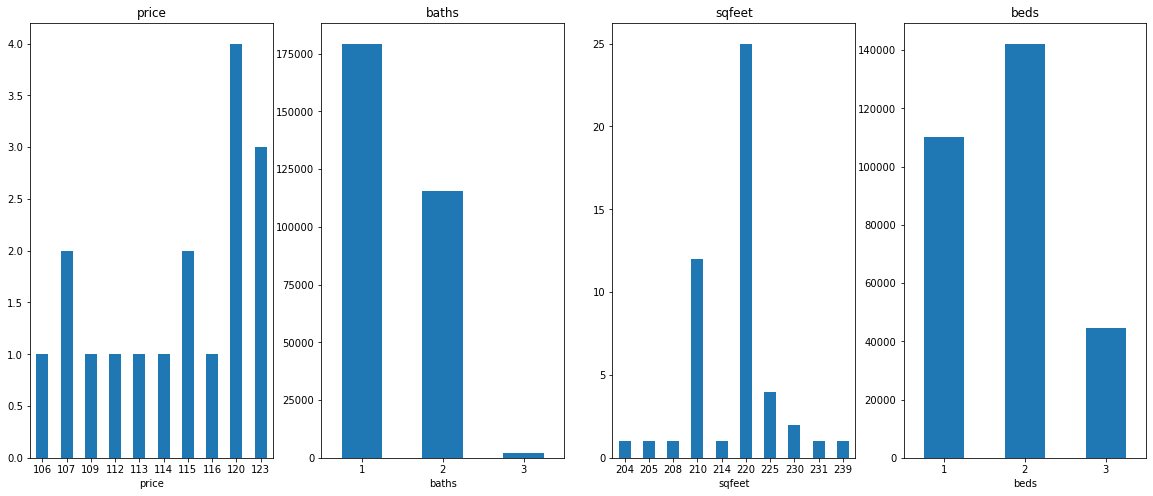

In [38]:
# Creating four histograms for the four main features of this dataframe.

fig, axs = plt.subplots(1, 4, figsize=(20, 8))
hdf.cols['price'].hist(ax=axs[0])
hdf.cols['baths'].hist(ax=axs[1])
hdf.cols['sqfeet'].hist(ax=axs[2])
hdf.cols['beds'].hist(ax=axs[3])

plt.show()

### Numeric and Categorical Data Exploration

Examining the numerical dataset after having removed the outliers.

In [39]:
# Selecting only the numerical features.
numeric_cols = ['price', 'sqfeet', 'beds', 'baths','cats_allowed', 'dogs_allowed', 'smoking_allowed',
                'wheelchair_access','electric_vehicle_charge','comes_furnished']

In [40]:
# Create an RDD using the numerical columns.
numeric_rdd = outliers_removed.select(numeric_cols).rdd.map(lambda row: [e for e in row])

# Calculate statistics on selected columns.
mllib_stats = st.Statistics.colStats(numeric_rdd)

# Print the mean and standard deviation for each columns.
for col, m, v in zip(numeric_cols, mllib_stats.mean(), mllib_stats.variance()):
    print(f'{col} - mean: {round(m,2)} - std: {round(np.sqrt(v),2)}')

price - mean: 1087.89 - std: 380.14
sqfeet - mean: 919.49 - std: 241.92
beds - mean: 1.78 - std: 0.69
baths - mean: 1.4 - std: 0.51
cats_allowed - mean: 0.74 - std: 0.44
dogs_allowed - mean: 0.72 - std: 0.45
smoking_allowed - mean: 0.75 - std: 0.43
wheelchair_access - mean: 0.08 - std: 0.27
electric_vehicle_charge - mean: 0.01 - std: 0.1
comes_furnished - mean: 0.04 - std: 0.19


It is interesting to note that the price and sqfeet features have a relatively small standard deviation meaning that 68% of properties converge around the mean.
Other notable mentions are that the wheel chair access and electric vehicle charging points are quite rare occurrences in the American market. Additionally most properties do not come furnished.

Examining the categorical dataset. All categorical unique values will be counted and displayed as a tuple denoting the number of times each unique value occurs.

Code sourced from Chapter 6 in Drabas, T., 2017. Learning PySpark.

In [41]:
# Selecting the categorical columns.
categorical_cols = ['type', 'laundry_options', 'parking_options', 'state', 'region']

categorical_rdd = outliers_removed\
    .select(categorical_cols)\
    .rdd \
    .map(lambda row: [e for e in row])
for i, col in enumerate(categorical_cols):
    agg = categorical_rdd \
        .groupBy(lambda row: row[i]) \
        .map(lambda row: (row[0], len(row[1])))
    print(col, sorted(agg.collect(), 
        key=lambda el: el[1], 
        reverse=True))

type [('apartment', 264695), ('house', 15730), ('townhouse', 3973), ('condo', 3826), ('duplex', 3677), ('manufactured', 3664), ('cottage/cabin', 544), ('loft', 492), ('flat', 377), ('in-law', 123), ('land', 4), ('assisted living', 1)]
laundry_options [('w/d in unit', 161261), ('w/d hookups', 56504), ('laundry on site', 47124), ('laundry in bldg', 29290), ('no laundry on site', 2927)]
parking_options [('off-street parking', 216168), ('carport', 32154), ('attached garage', 21481), ('detached garage', 12461), ('street parking', 12140), ('no parking', 2616), ('valet parking', 86)]
state [('fl', 25886), ('tx', 24760), ('ca', 20663), ('nc', 14583), ('ga', 11257), ('mi', 9995), ('oh', 8948), ('co', 8843), ('tn', 8832), ('sc', 7904), ('va', 7693), ('pa', 6992), ('il', 6549), ('ny', 6537), ('al', 6472), ('ia', 6013), ('or', 5899), ('la', 5845), ('mn', 5654), ('md', 5580), ('az', 5385), ('ks', 5334), ('in', 4883), ('wa', 4865), ('wi', 4802), ('ok', 4724), ('ut', 4283), ('ky', 4183), ('nj', 3884)

region [('jacksonville', 3844), ('fayetteville', 3154), ('columbus', 2893), ('jackson', 2792), ('rochester', 2444), ('omaha / council bluffs', 2401), ('salt lake city', 2318), ('orlando', 2296), ('savannah / hinesville', 2265), ('colorado springs', 2234), ('stockton', 2233), ('fort collins / north CO', 2216), ('lakeland', 2196), ('daytona beach', 2148), ('lincoln', 2142), ('greenville / upstate', 2140), ('space coast', 2137), ('memphis', 2107), ('augusta', 2104), ('reno / tahoe', 2093), ('inland empire', 2087), ('denver', 2073), ('boulder', 2064), ('tucson', 2060), ('austin', 2057), ('sarasota-bradenton', 2043), ('dallas / fort worth', 2031), ('atlanta', 2030), ('san marcos', 2026), ('charleston', 2024), ('lexington', 2009), ('tulsa', 2003), ('charlotte', 1985), ('kennewick-pasco-richland', 1981), ("spokane / coeur d'alene", 1971), ('sacramento', 1963), ('st louis, MO', 1956), ('norfolk / hampton roads', 1928), ('huntsville / decatur', 1915), ('ann arbor', 1913), ('minneapolis / st pau

Unfortunately there appears to be a large amount of incorrect data in the 'state' column of what appears to be comments or descriptions of the property. This feature needs to be cleaned up before proceeding further. This issue will cause havoc during the model training process and severely hurt the models ability to accurately predict the test set.

Removing all non-states from the column by identifying issue entries by their count values. Incorrect entries will have a very low count and this can be used to filter the dataframe as observed below.

In [42]:
# Identifying the correct states in the feature by filtering for count type and saving to a list.
state_names = outliers_removed.groupBy(outliers_removed.state).count().filter('count > 244').select('state').rdd.flatMap(lambda x: x).collect()

The counts were examined and a value of 244 was chosen to exactly filter out all issue entries.

In [43]:
# Filtering the dataframe for the named states only and saving to a new dataframe.
corrected_states_df = outliers_removed.filter(outliers_removed.state.isin(state_names))

In [44]:
# Verifying that the incorrect states have been removed successfully.
corrected_states_df.groupBy('state').count().orderBy('count', ascending=True).show()

+-----+-----+
|state|count|
+-----+-----+
|   me|  288|
|   vt|  359|
|   wv|  530|
|   hi|  831|
|   mt|  920|
|   nh| 1172|
|   ri| 1505|
|   sd| 1548|
|   mo| 1571|
|   ak| 1577|
|   dc| 1593|
|   de| 1604|
|   nm| 2058|
|   ne| 2174|
|   nv| 2333|
|   ar| 2527|
|   ct| 2604|
|   nd| 3151|
|   ma| 3179|
|   id| 3436|
+-----+-----+
only showing top 20 rows



### Examining Data Correlations

Taking a closer look at the data to determine the correlations between the features.

Code sourced from Chapter 6 in Drabas, T., 2017. Learning PySpark.

In [45]:
corrs = st.Statistics.corr(numeric_rdd)
for i, el in enumerate(corrs > 0.1):
    correlated = [
        (numeric_cols[j], corrs[i][j]) 
        for j, e in enumerate(el) 
    if e == 1.0 and j != i]
    if len(correlated) > 0:
        for e in correlated:
            print('{0}-to-{1}: {2:.2f}' \
             .format(numeric_cols[i], e[0], e[1]))

price-to-sqfeet: 0.32
price-to-beds: 0.15
price-to-baths: 0.24
sqfeet-to-price: 0.32
sqfeet-to-beds: 0.75
sqfeet-to-baths: 0.67
beds-to-price: 0.15
beds-to-sqfeet: 0.75
beds-to-baths: 0.63
baths-to-price: 0.24
baths-to-sqfeet: 0.67
baths-to-beds: 0.63
cats_allowed-to-dogs_allowed: 0.89
cats_allowed-to-wheelchair_access: 0.12
dogs_allowed-to-cats_allowed: 0.89
dogs_allowed-to-wheelchair_access: 0.13
wheelchair_access-to-cats_allowed: 0.12
wheelchair_access-to-dogs_allowed: 0.13
wheelchair_access-to-electric_vehicle_charge: 0.16
wheelchair_access-to-comes_furnished: 0.18
electric_vehicle_charge-to-wheelchair_access: 0.16
comes_furnished-to-wheelchair_access: 0.18


There are some interesting insights to be gained from this correlation extract. There appears to be a small correlation between price and square feet, which is to be expected as was explored in component 1. Furthermore there is also a strong correlation between square feet and the number of bedrooms in a property which makes sense as more rooms require additional living space. This also translates to the correlation between bedrooms and bathrooms, as additional bedrooms are usually accompanied by an increase in bathrooms. The square feet feature is also strongly influenced by the number of bathrooms in a property. The other less meaningful correlation is between the cats and dogs’ features. Typically a property either allows or denies pets and not specific animal species.

## One Hot Encoding

Categorical features are not accepted into a machine learning algorithm in its raw form. The features need to be transformed into numerical data type.

In [46]:
# Choosing categorical columns to encode.
categorical_cols = ['region', 'type', 'parking_options', 'laundry_options', 'state']

In [47]:
# Index each categorical column.
indexer = StringIndexer(inputCols=categorical_cols, outputCols=[x + '_idx' for x in categorical_cols])

In [48]:
# One hot encode each categorical column.
ohe = OneHotEncoder(inputCols=indexer.getOutputCols(), outputCols=[x + '_ohe' for x in categorical_cols])

In [49]:
# Create vectorizer from all independant variables.
vectorizer = VectorAssembler(inputCols = ['sqfeet', 'beds', 'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed', 
                                          'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished', 
                                          'region_ohe', 'type_ohe', 'parking_options_ohe', 'laundry_options_ohe', 
                                          'state_ohe'], 
                             outputCol = 'features')

In [50]:
# Creating pipeline to simplify process.
pipeline = Pipeline(stages=[indexer, ohe, vectorizer])

In [51]:
# Using pipeline to apply transformation to dataset.
encoded_df = pipeline.fit(corrected_states_df).transform(corrected_states_df)

## Scaling the Data

In addition to one hot encoding the categorical variables all independent features should also be scaled to assist with linear regression. The scaling method used is the standard scaler which normalises each feature to have a standard deviation of 1, the data is centered around the mean.

In [52]:
# Instantiating scaler.
scaler = StandardScaler(inputCol='features', outputCol='scaled_features',
                        withStd=True, withMean=False)

In [53]:
# Fitting and transforming the data.
scaled_df = scaler.fit(encoded_df).transform(encoded_df)

In [54]:
# Selecting just the two columns required for machine learning application.
test_df = scaled_df.select(['scaled_features', 'price'])

In [55]:
# Examining the test 
test_df.show()

+--------------------+-----+
|     scaled_features|price|
+--------------------+-----+
|(481,[0,1,2,30,41...|  895|
|(481,[0,1,2,3,4,3...| 1595|
|(481,[0,1,2,3,4,3...|  982|
|(481,[0,1,2,3,4,5...| 1295|
|(481,[0,1,2,3,4,5...| 1772|
|(481,[0,1,2,3,4,5...| 1745|
|(481,[0,1,2,3,4,5...| 1414|
|(481,[0,1,2,5,42,...| 1200|
|(481,[0,1,2,3,4,4...| 1635|
|(481,[0,1,2,3,4,5...| 1687|
|(481,[0,1,2,3,4,5...| 1125|
|(481,[0,1,2,3,4,4...| 1295|
|(481,[0,1,2,3,4,7...| 1835|
|(481,[0,1,2,3,4,5...| 1650|
|(481,[0,1,2,3,4,4...| 2099|
|(481,[0,1,2,3,4,5...| 2265|
|(481,[0,1,2,3,4,5...| 1786|
|(481,[0,1,2,3,4,7...| 1979|
|(481,[0,1,2,5,20,...| 1824|
|(481,[0,1,2,3,4,5...| 1345|
+--------------------+-----+
only showing top 20 rows



The data has been fully processed and is ready to be tested using machine learning algorithms.

### Chi Square Test

Conducting a Pearson's independence test on each feature against the label i.e. the price.

In [56]:
# Instantiating a chi square test.
chi_test = ChiSquareTest.test(test_df, 'scaled_features', 'price').head()

print(f'pValues: {chi_test.pValues}')
print(f'degreesOfFreedom: {chi_test.degreesOfFreedom}')
print(f'statistics: {chi_test.statistics}')

C:\ProgramData\Anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


pValues: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8577343808578061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9781088706918347,0.0,0.0,0.0,0.0,0.156144233537852,0.0,0.0,0.

## Model Testing

In this section a number of models will be trained and tested to select the model with low bias and good generalisation ability.

The model architectures to be tested are:
1. Linear Regression
2. Decision Tree Regressor
3. Gradient Boosted Tree Regressor
4. Random Forest

In [57]:
# Split data into train and test.
housing_train, housing_test = test_df.randomSplit([0.8, 0.2], seed=1)

### Linear Regression

Each model will be trained using a cross validator in order to minimise the potential error gained from splitting the data in a suboptimal manner. Additionally cross validation can systematically examine multiple parameters and build the model using the top performing hyperparameters.

In [58]:
# Instatiating linear regression model.
lr = LinearRegression(featuresCol='scaled_features', labelCol='price')

# Creating parameter grid search.
lr_param_grid = ParamGridBuilder() \
                .addGrid(lr.maxIter, [10,50,100]) \
                .addGrid(lr.regParam, [0.1,0.01,0.2]) \
                .build()

# Regression evaluator using mean absolute error.
lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='price', metricName='mae')

# Instantiating cross validator with three folds.
lr_cv = CrossValidator(estimator = lr,
                        estimatorParamMaps = lr_param_grid,
                        evaluator = lr_evaluator,
                        numFolds = 3)

# Train model using the train set.
lr_cv_model = lr_cv.fit(housing_train)

In [59]:
# Saving summary of best model into variable.
trainig_summary = lr_cv_model.bestModel.summary

print(f'MAE: {trainig_summary.meanAbsoluteError}')
print(f'MSE: {trainig_summary.meanSquaredError}')
print(f'RMSE: {trainig_summary.rootMeanSquaredError}')
print(f'Explained Variance: {trainig_summary.explainedVariance}')
print(f'R2:{trainig_summary.r2}')

MAE: 146.9173352099826
MSE: 42820.202913263565
RMSE: 206.9304301287357
Explained Variance: 100729.7084129398
R2:0.701917699817232


The MAE value is quite low at 146.9. This means that on average the model is off by this amount either below or above the actual price of the property. The R2 value is also quite high which implies that the independent features can somewhat reliably explain the variance observed in the dependant variable.

In [60]:
# Testing the model on the test set.
lr_predictions = lr_cv_model.transform(housing_test)

In [61]:
# Examining the predictions.
lr_predictions.select('prediction', 'price', 'scaled_features').show()

+------------------+-----+--------------------+
|        prediction|price|     scaled_features|
+------------------+-----+--------------------+
|  891.652748836528|  700|(481,[0,1,2,3,4,5...|
| 1201.979190402378|  850|(481,[0,1,2,3,4,5...|
|1655.1374789313131|  800|(481,[0,1,2,3,4,5...|
|1655.1374789313131|  800|(481,[0,1,2,3,4,5...|
|1255.9995405276532|  700|(481,[0,1,2,3,4,5...|
| 1412.969692828583| 1100|(481,[0,1,2,3,4,5...|
|1433.0849919499515| 1150|(481,[0,1,2,3,4,5...|
|1433.0849919499515| 1150|(481,[0,1,2,3,4,5...|
| 842.3451034759405|  750|(481,[0,1,2,3,4,5...|
| 1795.839593986469| 1600|(481,[0,1,2,3,4,5...|
|1467.7185581596113|  900|(481,[0,1,2,3,4,5...|
|1425.5144799835116|  950|(481,[0,1,2,3,4,5...|
| 995.7415568923839|  700|(481,[0,1,2,3,4,5...|
|1185.8293560218492|  800|(481,[0,1,2,3,4,5...|
|1331.5488752891192|  500|(481,[0,1,2,3,4,5...|
| 1377.258133475723|  800|(481,[0,1,2,3,4,5...|
|1162.7730154710296|  700|(481,[0,1,2,3,4,5...|
|1162.7730154710296|  700|(481,[0,1,2,3,

In [62]:
# Evaluating the model on the test set.
test_result_lr = lr_cv_model.bestModel.evaluate(housing_test)

print(f'MAE: {test_result_lr.meanAbsoluteError}')
print(f'MSE: {test_result_lr.meanSquaredError}')
print(f'RMSE: {test_result_lr.rootMeanSquaredError}')
print(f'Explained Variance: {test_result_lr.explainedVariance}')
print(f'R2:{test_result_lr.r2}')

MAE: 148.40644079471298
MSE: 44099.81774295522
RMSE: 209.99956605420695
Explained Variance: 100653.59824542458
R2:0.6944383426370304


The test results are also quite strong and most importantly in line with the training phase of the dataset. This implies that the model is regularised and can be used on new data with accuracy.

### Decision Tree Regressor

The same method will be used to create and test a multitude of parameters using the decision tree architecture.

In [63]:
# Instatiating decision tree regression model.
dt = DecisionTreeRegressor(featuresCol='scaled_features', labelCol='price')

# Creating parameter grid search.
dt_param_grid = ParamGridBuilder() \
                .addGrid(dt.maxDepth, [2,3,4,5]) \
                .addGrid(dt.maxBins, [16,32]) \
                .build()

# Regression evaluator using mean absolute error.
dt_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='price', metricName='mae')

# Instantiating cross validator with three folds.
dt_cv = CrossValidator(estimator = dt,
                        estimatorParamMaps = dt_param_grid,
                        evaluator = dt_evaluator,
                        numFolds = 3)

# Train model using the train set.
dt_cv_model = dt_cv.fit(housing_train)

In [64]:
# Testing the model on the test set.
dt_predictions = dt_cv_model.transform(housing_test)

In [65]:
# Examining the predictions.
dt_predictions.select('prediction', 'price', 'scaled_features').show()

+------------------+-----+--------------------+
|        prediction|price|     scaled_features|
+------------------+-----+--------------------+
| 857.4810878806281|  700|(481,[0,1,2,3,4,5...|
| 857.4810878806281|  850|(481,[0,1,2,3,4,5...|
|   1526.4330423324|  800|(481,[0,1,2,3,4,5...|
|   1526.4330423324|  800|(481,[0,1,2,3,4,5...|
| 892.9744694960212|  700|(481,[0,1,2,3,4,5...|
|1300.1114891062361| 1100|(481,[0,1,2,3,4,5...|
| 892.9744694960212| 1150|(481,[0,1,2,3,4,5...|
| 892.9744694960212| 1150|(481,[0,1,2,3,4,5...|
| 857.4810878806281|  750|(481,[0,1,2,3,4,5...|
| 1369.333850931677| 1600|(481,[0,1,2,3,4,5...|
| 892.9744694960212|  900|(481,[0,1,2,3,4,5...|
|1300.1114891062361|  950|(481,[0,1,2,3,4,5...|
| 873.9325842696629|  700|(481,[0,1,2,3,4,5...|
|  1033.83500056562|  800|(481,[0,1,2,3,4,5...|
| 892.9744694960212|  500|(481,[0,1,2,3,4,5...|
| 892.9744694960212|  800|(481,[0,1,2,3,4,5...|
| 892.9744694960212|  700|(481,[0,1,2,3,4,5...|
| 892.9744694960212|  700|(481,[0,1,2,3,

In [66]:
# Examining the predictions.
dt_evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='mae')

In [67]:
# Calculating the predictions 
mae_dt = dt_evaluator.evaluate(dt_predictions)

print(f'Decision tree MAE = {mae_dt}')

Decision tree MAE = 236.80276589792643


The test data MAE is a little higher than that of the linear regression. It is possible that the decision tree regression has overfit the training data as is typical of such a model. Sadly it is also not possible to extract the R2 value for comparison however it can be intuitively discerned that it is lower than that of linear regression.

### Gradient-boosted tree regression

In [68]:
# Instatiating gradient boosted tree regression model.
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='price')

# Creating parameter grid search.
gbt_param_grid = ParamGridBuilder() \
                .addGrid(gbt.maxDepth, [2,3,4,5]) \
                .addGrid(gbt.maxBins, [16,32]) \
                .build()

# Regression evaluator using mean absolute error.
gbt_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='price', metricName='mae')

# Instantiating cross validator with three folds.
gbt_cv = CrossValidator(estimator = gbt,
                        estimatorParamMaps = gbt_param_grid,
                        evaluator = gbt_evaluator,
                        numFolds = 3)

# Train model using the train set.
gbt_cv_model = gbt_cv.fit(housing_train)

In [69]:
# Testing the model on the test set.
gbt_predictions = gbt_cv_model.transform(housing_test)

In [70]:
# Examining the predictions.
gbt_predictions.select('prediction', 'price', 'scaled_features').show()

+------------------+-----+--------------------+
|        prediction|price|     scaled_features|
+------------------+-----+--------------------+
|   852.89787568731|  700|(481,[0,1,2,3,4,5...|
| 904.1096258523243|  850|(481,[0,1,2,3,4,5...|
|1508.0377673214205|  800|(481,[0,1,2,3,4,5...|
|1508.0377673214205|  800|(481,[0,1,2,3,4,5...|
|  898.121010396417|  700|(481,[0,1,2,3,4,5...|
|1273.1553068569633| 1100|(481,[0,1,2,3,4,5...|
|1013.3289403260069| 1150|(481,[0,1,2,3,4,5...|
|1013.3289403260069| 1150|(481,[0,1,2,3,4,5...|
| 829.4659611884978|  750|(481,[0,1,2,3,4,5...|
| 1704.447975945999| 1600|(481,[0,1,2,3,4,5...|
| 918.2992662029944|  900|(481,[0,1,2,3,4,5...|
|1325.4362858132092|  950|(481,[0,1,2,3,4,5...|
| 869.3493720763447|  700|(481,[0,1,2,3,4,5...|
| 1054.283697883549|  800|(481,[0,1,2,3,4,5...|
| 896.7663541856662|  500|(481,[0,1,2,3,4,5...|
| 879.8303500644096|  800|(481,[0,1,2,3,4,5...|
| 870.8265943229818|  700|(481,[0,1,2,3,4,5...|
| 870.8265943229818|  700|(481,[0,1,2,3,

In [71]:
# Creating the gbt evaluator.
gbt_evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='mae')

In [72]:
# Evaluating the model performance on the test set.
mae_gbt = gbt_evaluator.evaluate(gbt_predictions)

print(f'Gradient boosted Tree MAE = {mae_gbt}')

Gradient boosted Tree MAE = 197.0787244963996


Once again, the model performance is good but limited when compared to linear regression, which is regarded the simplest model. It is curious however how certain price labels are outperformed by the GBT model when comparing the prediction columns.

### Random Forest Regression

In [73]:
# Instatiating random forest regression model.
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='price')

# Creating parameter grid search.
rf_param_grid = ParamGridBuilder() \
                .addGrid(rf.maxDepth, [2,3,4,5]) \
                .addGrid(rf.maxBins, [16,32]) \
                .build()

# Regression evaluator using mean absolute error.
rf_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='price', metricName='mae')

# Instantiating cross validator with three folds.
rf_cv = CrossValidator(estimator = rf,
                        estimatorParamMaps = rf_param_grid,
                        evaluator = rf_evaluator,
                        numFolds = 3)

# Train model using the train set.
rf_cv_model = rf_cv.fit(housing_train)

In [74]:
# Testing the model on the test set.
rf_predictions = rf_cv_model.transform(housing_test)

In [75]:
# Examining the predictions.
rf_predictions.select('prediction', 'price', 'scaled_features').show()

+------------------+-----+--------------------+
|        prediction|price|     scaled_features|
+------------------+-----+--------------------+
| 958.4915366752779|  700|(481,[0,1,2,3,4,5...|
|1065.5314475652012|  850|(481,[0,1,2,3,4,5...|
| 1516.649633293997|  800|(481,[0,1,2,3,4,5...|
| 1516.649633293997|  800|(481,[0,1,2,3,4,5...|
|1186.1549054463171|  700|(481,[0,1,2,3,4,5...|
|1168.1051181291853| 1100|(481,[0,1,2,3,4,5...|
|1186.1549054463171| 1150|(481,[0,1,2,3,4,5...|
|1186.1549054463171| 1150|(481,[0,1,2,3,4,5...|
| 917.2181347816198|  750|(481,[0,1,2,3,4,5...|
|1293.9562196195898| 1600|(481,[0,1,2,3,4,5...|
|1186.1549054463171|  900|(481,[0,1,2,3,4,5...|
|1340.7458646374664|  950|(481,[0,1,2,3,4,5...|
| 1108.290677130974|  700|(481,[0,1,2,3,4,5...|
| 1071.046764743649|  800|(481,[0,1,2,3,4,5...|
|1112.8384540663856|  500|(481,[0,1,2,3,4,5...|
|1112.8384540663856|  800|(481,[0,1,2,3,4,5...|
|1191.5860571787491|  700|(481,[0,1,2,3,4,5...|
|1191.5860571787491|  700|(481,[0,1,2,3,

In [76]:
# Creating the gbt evaluator.
rf_evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='mae')

In [77]:
# Evaluating the model performance on the test set.
mae_rf = rf_evaluator.evaluate(rf_predictions)

print(f'Random Forest Tree MAE = {mae_rf}')

Random Forest Tree MAE = 237.05551304678906


The final model trained on this dataset is the random forest ensemble which unfortunately is once again beaten by the linear regression model by a substantial amount. The rf model appears to have centered around the 1000 price point mark with most values centering around this value, as observed from the prediction column.

It would appear that the linear regression model outperfromed the rest in this regard.

In [78]:
lr_predictions = lr_predictions.withColumnRenamed('prediction', 'lr_model')
rf_predictions = rf_predictions.withColumnRenamed('prediction', 'rf_model')
gbt_predictions = gbt_predictions.withColumnRenamed('prediction', 'gbt_model')
dt_predictions = dt_predictions.withColumnRenamed('prediction', 'dt_model')

In [79]:
model_results = lr_predictions.join(rf_predictions.select('rf_model', 'price'),on='price', how='outer')\
                               .join(gbt_predictions.select('gbt_model', 'price'),on='price', how='outer')\
                               .join(dt_predictions.select('dt_model', 'price'),on='price', how='outer')

In [94]:
model_results.show(10)

+-----+--------------------+-----------------+------------------+-----------------+-----------------+
|price|     scaled_features|         lr_model|          rf_model|        gbt_model|         dt_model|
+-----+--------------------+-----------------+------------------+-----------------+-----------------+
|  471|(481,[0,1,2,5,64,...|700.0655572838768|1059.7087399682682|905.6168419162514|1023.295374800638|
|  471|(481,[0,1,2,5,64,...|700.0655572838768|1059.7087399682682|905.6168419162514|1023.295374800638|
|  471|(481,[0,1,2,5,64,...|700.0655572838768|1059.7087399682682|905.6168419162514|1023.295374800638|
|  471|(481,[0,1,2,5,64,...|700.0655572838768|1059.7087399682682|905.6168419162514|1023.295374800638|
|  471|(481,[0,1,2,5,64,...|700.0655572838768|1059.7087399682682|905.6168419162514|1023.295374800638|
|  471|(481,[0,1,2,5,64,...|700.0655572838768|1059.7087399682682|905.6168419162514|1023.295374800638|
|  471|(481,[0,1,2,5,64,...|700.0655572838768|1059.7087399682682|905.6168419162514